<a target="_blank" href="https://colab.research.google.com/github/ArtificialIntelligenceToolkit/aitk/blob/master/notebooks/Advanced/EvolvingRobotControl.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evolving Robot Control

In this essay, we explore using a Genetic Algorithm to evolve a neural network to control a robot. Our goal is to develop a controller that will maximize the distance the robot travels in a fixed number of steps. To accomplish this, the controller will need to maneuver the robot around within a relatively small world. We will equip the robot a ring of range sensors to help it sense the distances to near by obstacles.

In [1]:
%pip install aitk --quiet

We import everything needed in this cell:

In [2]:
from aitk.algorithms.ga import GeneticAlgorithm
from aitk.robots import World, Scribbler, RangeSensor
from aitk.networks import SequentialNetwork
from aitk.robots.utils import distance
import random

## The Genetic Algorithm

The [Genetic Algorithm](https://en.wikipedia.org/wiki/Genetic_algorithm) (GA) is an approach inside the category of machine learning systems called [Evolutionary Computation](
https://en.wikipedia.org/wiki/Evolutionary_computation). For this essay, we will use the GA as follows:

1. We will define a `gene` to be a floating-point number that represents the weight or bias of a neural network.
2. We will define a `chromosome` as a sequence of genes. The chromosome will represent all of the weights and biases of a sequential network that takes sensor readings as inputs and produces robot actions as output.
3. A `population` will be composed of a collection of chromosomes.

The length of each chromosome is determined by the size of the neural network, which will depend on how many sensors the robot has and on how we will represent the robot's actions. We can also specify the size and number of additional hidden layers between the input and output layers of the network.

The robot has a ring of 16 range sensors that we will use as input to the network. The robot's actions will be encoded as two values representing translation and rotation amounts for its movement. We will include a single hidden layer of size 4. In summary, the network will have 16 inputs, fed through 4 hiddens, to 2 outputs.

The basic idea is that we will have a list of weights and biases (the chromosome) that we load into the neural network. The sensors will be read, and propagated through the neural network. The output of the neural network will be interpreted as movement controls. We'll let the neural network "drive" the robot around the world starting a small set of locations, and we will measure how far the robot moves from its starting location. This distance will serve as the fitness score for each chromosome in the population.

We will incrementally build a new class call **NNGA** which is short for Neural Network Genetic Algorithm. Note that it inherits from the base class **GeneteticAlgorithm**. Here we start with the constructor.

In [3]:
class NNGA(GeneticAlgorithm):
    """
    An example of using the GeneticAlgorithm class to
    evolve the weights of a neural network to control
    a simulated robot.
    """
    def __init__(self, popsize, sensors=16):
        self.show = False
        self.sensors = sensors
        self.world = World(100, 100)
        self.robot = Scribbler()
        # We add a ring of RangeSensors, 8cm from
        # the robot center, starting and ending
        # at the back of the robot
        # with 75cm max range, and sensor width 0
        # which makes it a laser range finder
        self.robot.add_device_ring(
            RangeSensor, 8, -180, 180,
            self.sensors, max=75, width=0)
        self.world.add_robot(self.robot)
        self.network = self.build_model()
        # Starting poses to test from:
        self.poses = [
            (20, 20, 0),
            (20, 20, 45),
            (20, 20, 90),
            (20, 20, 180),
            (20, 20, -45),
        ]
        # Length of a chromosome:
        length = len(self.network.get_weights(flat=True))
        super().__init__(length, popsize)

As mentioned, a chromosome will be a sequence of floating-point numbers. For this problem we will initialize them to be between -2 and +2. When we mutate such a gene, we will increase or decrease it a small amount.

Next we add methods to the **NNGA** class to create random genes and to mutate them.

In [4]:
class NNGA(NNGA):
    def make_random_gene(self):
        """
        Generate a random weight for the neural network.
        """
        # range of [-2, +2]
        return 2 - random.random() * 4

    def mutate_gene(self, gene):
        """
        Given a gene, mutate it a little.
        """
        # range of [-0.5, +0.5]
        return gene + (0.5 - random.random())

### The Fitness Function

To use a GA we need to define a `fitness function`. A fitness function tests a chromosome in the simulated world, and returns a value that represents how "apt" (or fit) it is relative to the other chromosomes in the population at this generation.

Finding a good fitness function is difficult. We don't want to be too prescriptive, or the system will evolve exactly what we have defined it to do. On the other hand, we don't want to be too open, as that can leave the system to evolve solutions that don't really "solve a problem."

For example, let's say that we want the robot to move around this world and not bump into walls. We could define a fitness that is the total number of steps where the robot did not hit a wall (e.g., `robot.stalled` is not True).

<div class="alert alert-block alert-warning">
    <b>Warning</b>: The GA implementation that we use here expects the fitness function to return non-negative values.
</div>

However, you would very quickly evolve a robot that doesn't move. No movement, no crashing into walls! Well, ok, then. How about we define a fitness function that rewards the robot when it keeps moving. The evolutionary system could "solve that problem" by simply spinning the robot in circles. Foiled again!

You could then define a fitness function that rewards the robot when it has forward movement, thereby circumventing the solution for the robot to spin in circles. However, the system could then just drive the robot in small circles.

The search the human performs in attempting to find a good fitness function that will drive the robot into interesting control patterns while not settling on simplistic solutions is quite common. However, if you can train yourself to think more like nature, you can end up with some very clever robots.

To that end, we will define the fitness function to be the distance between where the robot started, and where it ended up after a given number of seconds. However, if it ends up against a wall, it will get a score of zero. Plus, we will add all of the distances traveled over a set of starting poses.

This is a fairly easy fitness function to compute and should bypass some of the issues raised above.

Below we add the **fitness** method to the **NNGA** class.

In [5]:
class NNGA(NNGA):
    def fitness(self, chromosome, index=None, poses=None, seconds=None, interrupt=True, real_time=False,
                show=False, show_progress=False, quiet=True):
        """
        Fitness is based on the distance the robot travels
        from starting pose to ending pose.

        Args:
            poses: default None, all of the poses;
                otherwise list of poses (x, y, a).
            seconds: default 10
            interrupt: default True
            real_time: default False
            show: default True
            show_progress: default False
            quiet: default True
        """
        if seconds is None:
            seconds = min(self.generation / 10, 10)
        self.show = show
        self.network.set_weights(chromosome)
        score = 0
        poses = poses if poses is not None else self.poses
        for pose in poses:
            self.robot.set_pose(*pose, show=self.show)
            self.world.seconds(
                seconds, self.controller,
                interrupt=interrupt,
                real_time=real_time, show=show,
                show_progress=show_progress, quiet=quiet)
            if not self.robot.stalled:
                end_pose = self.robot.get_pose()
                score += distance(pose[0], pose[1], end_pose[0], end_pose[1])
        return score

We can now add some methods for the specific problem:

* **build_model** - creates the neural network and takes in the number of sensors, and outputs the movement commands (one for translate, one for rotate)
* **controller** - the method to drive the robot
* **get_sensors** - a convenience method to get the sensor readings from the range sensors as a list
* **get_move** - a method that takes the input to the network (the sensor readings) and propagates them through the network to get the output values, which are scaled to [-1, +1]

In [6]:
class NNGA(NNGA):
    def build_model(self):
        """
        We build a simple network.
        """
        return SequentialNetwork(
            self.sensors,
            4,
            2,
            activation="sigmoid"
        )

    def controller(self, world):
        """
        The controller for the robot.
        """
        sensors = self.get_sensors()
        output = self.get_move(sensors)
        self.robot.move(output[0], output[1])

    def get_sensors(self):
        """
        We return the sensors from the robot.
        """
        return [sensor.get_reading()
                for sensor in self.robot]

    def get_move(self, sensors):
        """
        Return scaled network output after
        propagating the given sensors.
        """
        # Propagate takes a single pattern:
        output = self.network.propagate(sensors)
        # Scale the output in  the range [-1, 1]
        return [1 - (x * 2) for x in output]


Now, we are ready to create a GA. We'll define the population size to be 30, which isn't too small, but big enough to evolve a solution in a few minutes.

In [7]:
ga = NNGA(popsize=30)

Random seed set to: 7522856
Genetic algorithm
  Chromosome length: 78
  Population size: 30


### Testing

Let's test everything to make sure it is working.

Let's see how long a chromosome will be:

In [8]:
len(ga.make_random_chromosome())

78

Does this make sense? Let's calculate how many weights and biases are in this network:
* Weights between input and hidden layers 16*4 = 64
* Weights between hidden and output layers 4*2 = 8
* Bias for all non-input layers 4 + 2 = 6
* Total = 64 + 8 + 6 = 78

Yes, this matches our expectation.


Let's get a snapshot of the robot in its world.

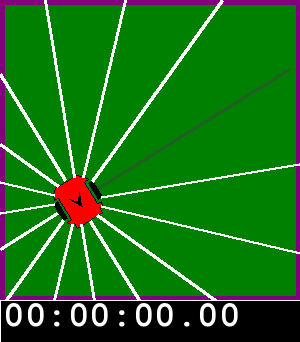

In [9]:
ga.world.display()

Let's see what the sensor readings look like. We are expecting 16 floating point numbers representing distances to obstacles. The smaller the value the closer the obstacle.

In [10]:
ga.get_sensors()


[0.552133387535386,
 0.3204885317955284,
 0.24948137593779593,
 0.24456700199504225,
 0.30100614396710623,
 0.43549185445842703,
 0.34536738740822837,
 0.33912991278857946,
 0.4107642083685068,
 0.6464302531900482,
 0.9069854545921887,
 0.8929983902935815,
 1.0,
 0.9940794216782204,
 0.8110994431217564,
 0.7984354795000448]

And let's see what movements the sensors give when propagated through the network and scaled. The first value respresents translation (where a positive value represents forward motion and negative backward motion). The second value represents rotation (where a positive value represents left rotation and a negative right rotation).

In [11]:
ga.get_move(ga.get_sensors())

[0.11275631189346313, 0.07205820083618164]

We can get a snapshot of the network architecture using the robot's current sensor values:



In [12]:
ga.network.display(ga.get_sensors())

We can watch how the world changes over time with by using the **watch** command.

NOTE: Whenever you run a command that moves the robot, scroll back up to this picture to see it moving.

In [13]:
ga.world.watch()

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x0…

Ok, let's put all of this together and move the robot around the simulated world. We can test out a random chromosome to see what this does.

We pass in:

1. a random chromosome (like one from the initial population)
2. A list of poses (x, y, angle) to test
3. number of seconds to run the simulation
4. Whether we should show the robot and network updates
5. Whether the simulation should run in real_time (setting to False will run as fast as possible)

Let's go!

In [14]:
ga.fitness(
    ga.make_random_chromosome(),
    poses=[(50, 50, 0)],
    seconds=5,
    show=True,
    real_time=True)

  0%|          | 0/50 [00:00<?, ?it/s]

0.7849689857455038

Interesting! You can try that cell over and over again to see many possible behaviors of these random weights.

Some questions you might be interested in answering at this point?

1. What percentage of random chromosoves spin in circles?
2. What percentage of random chromosomes change movement during the 5 seconds of training?
3. What percentage of random chromosomes actually make it to a wall?
4. What is the range of "fitness" values returned for these random chromosomes?

## Evolve!

To run 10 generations (plus one to test initial population) for a population of size 30, in the 5 test poses for 3 seconds each will take 1 hour, 22 minutes, and 30 seconds of simulated time.

Often, 10 simulated generations can performed in a few actual clock minutes on a typical computer. One can get about a 50 x speed-up over real time when not watching the network, and about 10 x speed-up when watching the network.

You can run without watching by setting `show=False`.

In [15]:
%%time
ga.reset()
ga.world.reset()
bestFound = ga.evolve(
    generations=10,
    crossover_rate=0.1,
    mutation_rate=0.6,
    elite_percent=0.05,
    seconds=3,
    show=False,
)

Using random seed: 7522856
Maximum number of generations: 10
  Elite percentage 0.05 (1/30 chromosomes per generation)
  Crossover rate: 0.1 (~2/29 crossovers per generation)
  Mutation rate: 0.6 (~1357/2262 genes per generation)
Evaluating initial population...
Done!


  0%|          | 0/10 [00:00<?, ?it/s]

Generation    1 Best fitness 146.02
Generation    2 Best fitness 150.33
Generation    3 Best fitness 150.33
Generation    4 Best fitness 158.70
Generation    5 Best fitness 177.04
Generation    6 Best fitness 177.04
Generation    7 Best fitness 177.04
Generation    8 Best fitness 178.40
Generation    9 Best fitness 178.40
Generation   10 Best fitness 183.58
Max generations reached
CPU times: user 2min 39s, sys: 2.84 s, total: 2min 42s
Wall time: 2min 42s


## Analysis

Here's a summary of how the best and average fitness for the population changed over time:

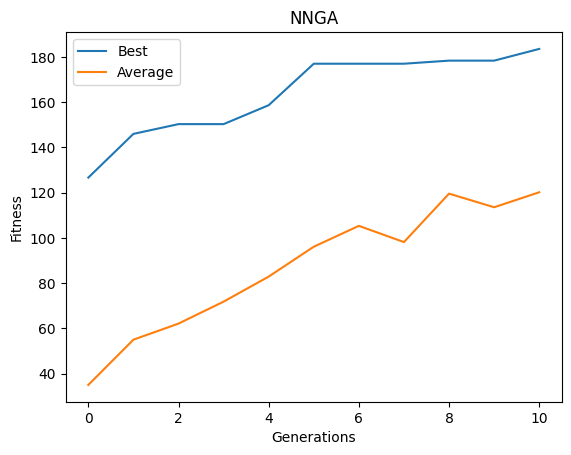

In [16]:
ga.plot_stats("NNGA")

Let's see the results by trying the best ever over the poses, for 5 seconds each. Remember to scroll back up to watch the world after you execute the next cell. You should see the robot placed in 5 different poses (notice that its x, y location remains the same, but its heading changes each time).

In [17]:
ga.fitness(
    ga.bestEver,
    real_time=True,
    show=True,
    seconds=5)

  0%|          | 0/50 [00:00<?, ?it/s]

208.93140401658894

Hopefully, the evolutionary process found behaviors that drive the robot away from walls allowing it to travel some distance away from its starting point.


## Further Exploration

If you wish, you can increase the maximum generations, change any of the parameters, and continue to evolve:

In [18]:
bestFound = ga.evolve(
    generations=15,
    crossover_rate=0.1,
    mutation_rate=0.6,
    elite_percent=0.05,
    seconds=3,
    show=False,
)

Maximum number of generations: 15
  Elite percentage 0.05 (1/30 chromosomes per generation)
  Crossover rate: 0.1 (~2/29 crossovers per generation)
  Mutation rate: 0.6 (~1357/2262 genes per generation)


  0%|          | 0/5 [00:00<?, ?it/s]

Generation   11 Best fitness 217.60
Generation   12 Best fitness 223.35
Generation   13 Best fitness 223.35
Generation   14 Best fitness 224.53
Generation   15 Best fitness 224.53
Max generations reached


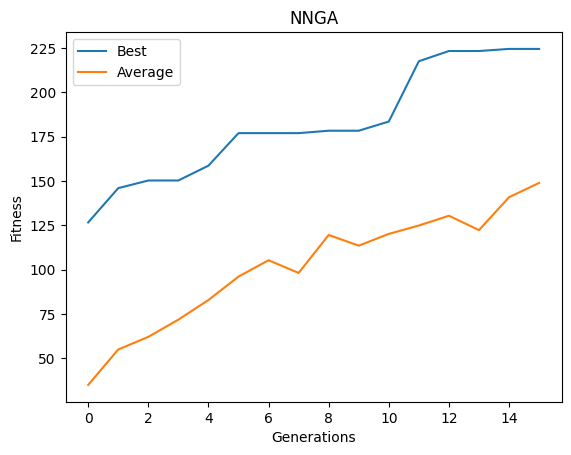

In [19]:
ga.plot_stats("NNGA")

In [20]:
ga.fitness(
    ga.bestEver,
    real_time=True,
    show=True,
    seconds=5,
)

  0%|          | 0/50 [00:00<?, ?it/s]

366.60133152929853

Was the best from 15 generations significantly different from the best from the first 10 generations?

Did the fitness change dramatically during the furtner generations?

Do you think there will be a point where the fitness won't get any higher?

Some other ideas to consider:

* What happens if you try with a larger, fixed number of seconds for the fitness function, such as 10?
* The above experiments used a low crossover rate with a high mutation rate. What happens if you reverse this?
* Anything that you can represent with a list of numbers and create a fitness function for, you could conceivably evole. What else could you try? What are the limitations of the GA?